In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

SEEDS = [40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
TEST_SPLIT_SEED = 40   # 테스트셋은 한 번만 고정

def rmse(y_true, y_pred):
    # 버전 의존 옵션 없이 직접 계산
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [9]:
CSV_PATH = "wildfire_preprocessed_V1.csv"
TARGET   = "FIRE_SUPESN_HR"

df = pd.read_csv(CSV_PATH)
print("[STEP0] 데이터 로드:", df.shape)
display(df.head(10))

X = df.drop(columns=[TARGET])
y = df[TARGET].values


[STEP0] 데이터 로드: (3359, 66)


,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_남동,WNDRCT_BRNG_남서,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12
5,6.338594,9.894396,3.367296,2.197225,2.3,38.0,1,12,0,0,...,0,0,0,0,1,5.298317,6.639876,1,0,12
6,6.476972,8.777093,1.791759,2.079442,-2.9,36.0,5,12,0,0,...,0,0,1,0,0,3.737670,6.538140,1,1,12
7,6.089045,8.806724,3.178054,2.564949,-1.2,89.0,1,1,0,0,...,0,0,0,1,0,1.945910,6.102559,1,0,1
8,5.749393,0.000000,2.197225,0.693147,10.2,35.0,1,12,0,0,...,1,0,0,0,0,4.343805,5.966147,1,0,12
9,7.049255,8.601167,3.178054,2.772589,12.9,26.0,1,12,0,0,...,0,0,0,0,1,3.044522,7.066467,1,0,12


In [10]:
print("\n[STEP1] EDA 요약")
print("자료형 빈도:")
print(df.dtypes.value_counts(), "\n")

print("기초통계(숫자형):")
display(df.describe().T)

print("결측치 Top10:")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))



[STEP1] EDA 요약
자료형 빈도:
int64      58
float64     8
Name: count, dtype: int64 

기초통계(숫자형):


,count,mean,std,min,25%,50%,75%,max
DSPT_REQ_HR,3359.0,6.347238,0.630339,0.0,5.888878,6.364751,6.776507,9.709235
FIRE_SUPESN_HR,3359.0,8.052170,1.442208,0.0,7.376508,8.175829,8.865947,11.354211
FRSTN_GRNDS_DSTNC,3359.0,2.610196,0.739633,0.0,2.197225,2.708050,3.135494,4.605170
CNTR_GRNDS_DSTNC,3359.0,1.988543,0.786945,0.0,1.386294,2.079442,2.564949,4.317488
HR_UNIT_ARTMP,3359.0,13.122715,8.507974,-15.3,7.200000,13.500000,19.200000,36.000000
...,...,...,...,...,...,...,...,...
dispatch_time_diff,3359.0,4.070910,0.980141,0.0,3.850148,4.143135,4.532599,8.665441
arrival_time_diff,3359.0,6.491795,0.579521,0.0,6.049733,6.490724,6.859615,11.385910
golden_time_under_50min,3359.0,0.993153,0.082477,0.0,1.000000,1.000000,1.000000,1.000000
is_night,3359.0,0.123549,0.329115,0.0,0.000000,0.000000,0.000000,1.000000


결측치 Top10:


DSPT_REQ_HR                 0
FND_IGTN_PSTN_NM_unknown    0
CTPV_NM_gyeongbuk           0
CTPV_NM_gyeonggi            0
CTPV_NM_gyeongnam           0
CTPV_NM_incheon             0
CTPV_NM_jeju                0
CTPV_NM_jeonbuk             0
CTPV_NM_jeonnam             0
CTPV_NM_sejong              0
dtype: int64

In [11]:
print("\n[STEP2] GridSearchCV (XGBoost, 작은 탐색공간, RMSE 커스텀 스코어)")

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)  # 작을수록 좋음 → 음수

param_grid = {
    "n_estimators":     [600, 1000],
    "max_depth":        [4, 6, 8],
    "learning_rate":    [0.03, 0.05, 0.10],
    "subsample":        [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda":       [0.0, 1.0],
    "reg_alpha":        [0.0, 0.1],
}

base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X, y)

best_params = grid.best_params_
best_rmse_cv = -grid.best_score_  # 부호 반전

print("Best Params:", best_params)
print(f"Best CV RMSE: {best_rmse_cv:.4f}")



[STEP2] GridSearchCV (XGBoost, 작은 탐색공간, RMSE 커스텀 스코어)
Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.9}
Best CV RMSE: 1.3672


In [5]:
print("\n[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정")

# Test 20% 고정
X_rem, X_test, y_rem, y_test = train_test_split(
    X, y, test_size=0.2, random_state=TEST_SPLIT_SEED, shuffle=True
)

records = []

for i, seed in enumerate(SEEDS, start=1):
    # Train:Val = 6:2 (즉, 남은 80%에서 75:25)
    X_train, X_val, y_train, y_val = train_test_split(
        X_rem, y_rem, test_size=0.25, random_state=seed, shuffle=True
    )

    # 5-Fold CV on Train
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rmse_cv, mae_cv, r2_cv = [], [], []

    for tr_idx, va_idx in kf.split(X_train):
        model_cv = XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
            random_state=seed,
            **best_params
        )
        model_cv.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        pred_cv = model_cv.predict(X_train.iloc[va_idx])
        rmse_cv.append(rmse(y_train[va_idx], pred_cv))
        mae_cv.append(mean_absolute_error(y_train[va_idx], pred_cv))
        r2_cv.append(r2_score(y_train[va_idx], pred_cv))

    # 최종 재학습 (Train+Val = 80%) 후, 고정 Test 평가
    X_fit = pd.concat([X_train, X_val], axis=0)
    y_fit = np.concatenate([y_train, y_val], axis=0)

    model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        random_state=seed,
        **best_params
    )
    model.fit(X_fit, y_fit)

    pred_test = model.predict(X_test)
    rmse_test = rmse(y_test, pred_test)
    mae_test  = mean_absolute_error(y_test, pred_test)
    r2_test   = r2_score(y_test, pred_test)

    rec = {
        "seed": seed,
        "rmse_cv": np.mean(rmse_cv),
        "mae_cv":  np.mean(mae_cv),
        "r2_cv":   np.mean(r2_cv),
        "rmse_test": rmse_test,
        "mae_test":  mae_test,
        "r2_test":   r2_test
    }
    records.append(rec)
    print(f"Run {i:>2}/10 (seed={seed}) → "
          f"RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, R²={r2_test:.4f}")

df_runs = pd.DataFrame(records)
print("\n개별 결과 미리보기:")
display(df_runs.head())

print("\n=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===")
for m in ["rmse_test", "mae_test", "r2_test"]:
    mean, std = df_runs[m].mean(), df_runs[m].std()
    label = m.replace("_test","").upper()
    print(f"{label:>4} = {mean:.4f} ± {std:.4f}")



[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정
Run  1/10 (seed=40) → RMSE=1.3183, MAE=0.8913, R²=0.1749
Run  2/10 (seed=41) → RMSE=1.3190, MAE=0.8904, R²=0.1740
Run  3/10 (seed=43) → RMSE=1.3135, MAE=0.8870, R²=0.1809
Run  4/10 (seed=44) → RMSE=1.3196, MAE=0.8883, R²=0.1733
Run  5/10 (seed=45) → RMSE=1.3075, MAE=0.8883, R²=0.1884
Run  6/10 (seed=46) → RMSE=1.3083, MAE=0.8889, R²=0.1874
Run  7/10 (seed=47) → RMSE=1.3179, MAE=0.8934, R²=0.1754
Run  8/10 (seed=48) → RMSE=1.3036, MAE=0.8839, R²=0.1932
Run  9/10 (seed=49) → RMSE=1.3145, MAE=0.8877, R²=0.1797
Run 10/10 (seed=50) → RMSE=1.3106, MAE=0.8842, R²=0.1845

개별 결과 미리보기:


,seed,rmse_cv,mae_cv,r2_cv,rmse_test,mae_test,r2_test
0,40,1.285195,0.880525,0.126672,1.318325,0.891321,0.174898
1,41,1.335886,0.904143,0.104698,1.319025,0.890426,0.174022
2,43,1.389413,0.928918,0.097951,1.313504,0.887034,0.180921
3,44,1.349307,0.900312,0.103092,1.319598,0.888331,0.173303
4,45,1.391328,0.934756,0.091952,1.307455,0.888300,0.188448



=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===
RMSE = 1.3133 ± 0.0056
 MAE = 0.8884 ± 0.0029
  R2 = 0.1812 ± 0.0070



[STEP4] Feature Importance Top 10 (gain 기준, Train+Val로 재학습, seed=42)


,feature,gain
0,CTPV_NM_gyeonggi,20.798903
1,CMBS_EXPOBJ_LCLSF_NM_nan,16.171125
2,CTPV_NM_gangwon,11.784170
3,FND_IGTN_PSTN_NM_under,11.672935
4,CTPV_NM_seoul,10.390437
5,CTPV_NM_ulsan,10.085684
6,FND_IGTN_PSTN_NM_top,9.407542
7,CNTR_GRNDS_DSTNC,9.336621
8,FND_FIRE_SE_NM_public,9.309334
9,FND_IGTN_PSTN_NM_plain,8.936011


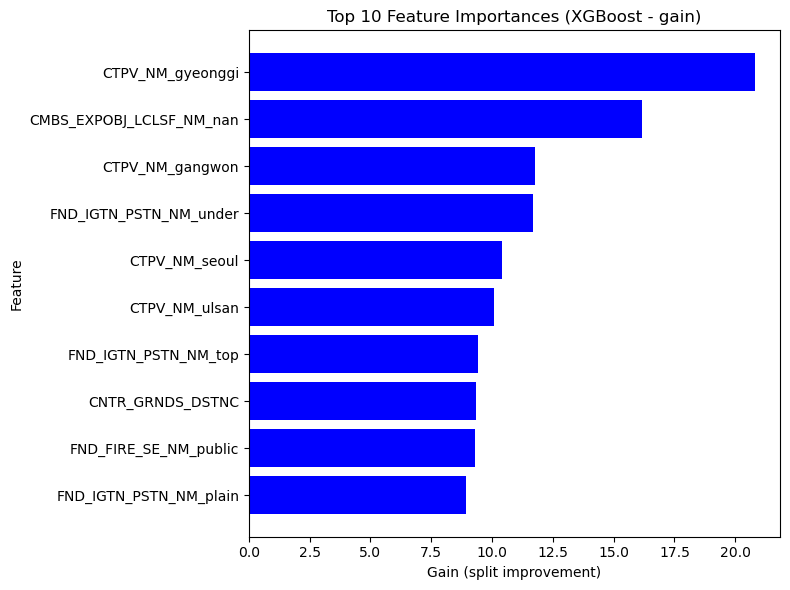

In [14]:
print("\n[STEP4] Feature Importance Top 10 (gain 기준, Train+Val로 재학습, seed=42)")

model_imp = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    **best_params
)
model_imp.fit(X_rem, y_rem)   # 80% (Train+Val)

booster = model_imp.get_booster()
score_dict = booster.get_score(importance_type='gain')  # dict: {feature_name: gain}

# 키가 f0,f1... 형태일 수도 있으므로 안전 매핑
def _map_gain_dict(score_dict, booster, X_cols):
    keys = list(score_dict.keys())
    # f0 패턴 감지
    is_f_pattern = all(k.startswith('f') and k[1:].isdigit() for k in keys) if keys else False
    if is_f_pattern:
        feature_names = booster.feature_names or list(X_cols)
        mapped = {feature_names[int(k[1:])]: v for k, v in score_dict.items()}
    else:
        mapped = score_dict
    # 모든 피처에 대해 값 준비(없으면 0)
    gains = [mapped.get(col, 0.0) for col in X_cols]
    return gains

gains = _map_gain_dict(score_dict, booster, X.columns)
fi_df = pd.DataFrame({"feature": X.columns, "gain": gains}).sort_values("gain", ascending=False)
fi_top10 = fi_df.head(10).reset_index(drop=True)
display(fi_top10)

# 그래프 (Top10만)
plt.figure(figsize=(8, 6))
plt.barh(fi_top10["feature"][::-1], fi_top10["gain"][::-1], color='Blue')
plt.xlabel("Gain (split improvement)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (XGBoost - gain)")
plt.tight_layout()
plt.show()



[STEP5] SHAP Top 10


/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 51064 

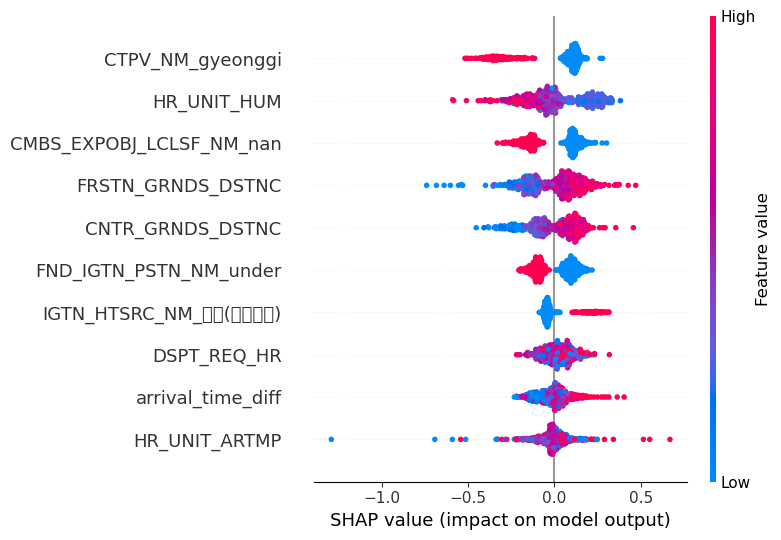

In [13]:
print("\n[STEP5] SHAP Top 10")

import shap
# 연산량 관리: Test에서 최대 2000행만 사용
sample_n = min(2000, len(X_test))
X_sample = X_test.sample(sample_n, random_state=42)

explainer = shap.TreeExplainer(model_imp)
_sv = explainer.shap_values(X_sample)
shap_values = _sv[0] if isinstance(_sv, list) else _sv  # 회귀는 보통 ndarray, 방어 코드

shap.summary_plot(
    shap_values,
    X_sample,
    max_display=10,
    show=True
)
